# Quickstart

Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

This package is meant to get you from chromatogram to quantified peaks as rapidly 
as possible. Below is a brief example of how to go from a raw, off-the-machine 
data set to a list of compounds and their absolute concentrations.   

## Loading and viewing chromatograms
Text files containing chromatograms with time and signal information can be intelligently read into a pandas DataFrame using `hplc.io.load_chromatogram()`.

In [43]:
# Load the chromatogram as a dataframe
from hplc.io import load_chromatogram
df = load_chromatogram('data/sample.txt', 
                                 cols=['R.Time (min)', 'Intensity'])
df.head()

,R.Time (min),Intensity
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


By providing the column names as a dictionary, you can rename the (often annoying)
default column names to something easier to work with, such as "time" and "signal"
as 

In [44]:
# Load chromatogram and rename the columns
df = load_chromatogram('data/sample.txt', cols={'R.Time (min)':'time',
                                                              'Intensity': 'signal'})
df.head()

,time,signal
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


This dataframe can now be loaded passed to the `Chromatogram` class, which 
has a variety of methods for quantification, cropping, and visualization and
more.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

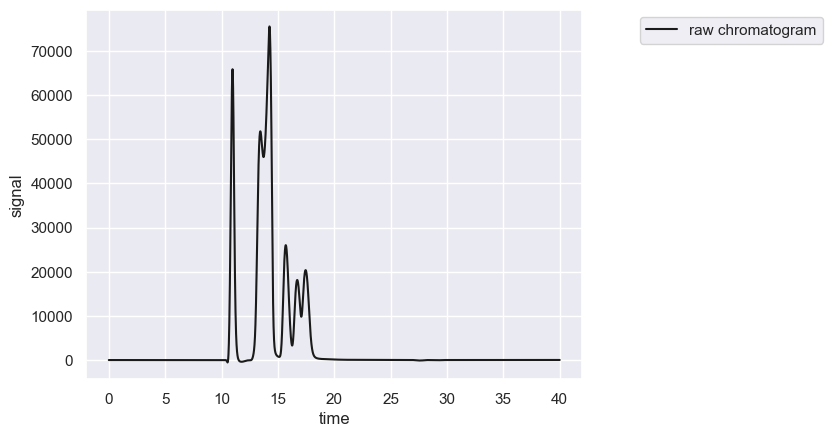

In [45]:
# Instantiate the Chromatogram class with the loaded chromatogram.
from hplc.quant import Chromatogram
chrom = Chromatogram(df)

# Show the chromatogram
chrom.show()

The `crop` method allows you to crop the chromatogram *in place* to restrict
the signal to a specific time range.  


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

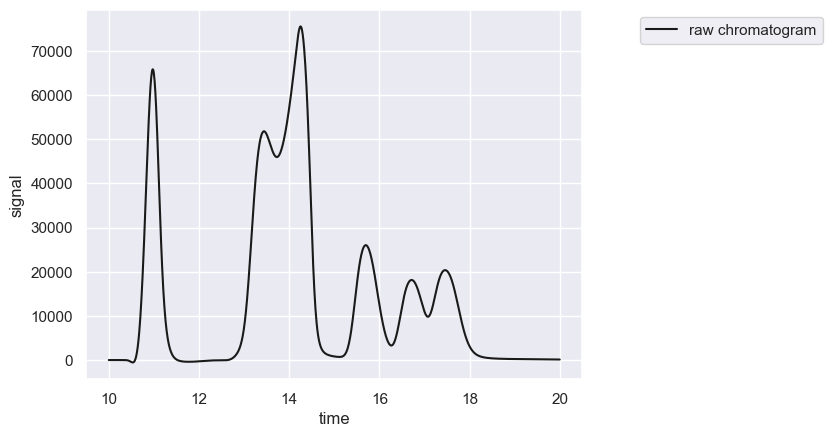

In [47]:
# Crop the chromatogram in place between 8 and 21 min.
chrom.crop([10, 20])
chrom.show()

Note that the crop function operates **in place** and modifies the loaded as data
within the `Chromatogram` object.

## 

## Detecting and Fitting Peaks
The real meat of the package comes in the deconvolution of signal into discrete
peaks and measurement of their properties. This typically involves the automated estimation and subtraction of the baseline,
detection of peaks, and fitting of skew-normal distributions to reconstitute the 
signal. Luckily for you, all of this is done in a single method call `Chromatogram.fit_peaks()`

In [49]:
# Automatically detect and fit the peaks 
peaks = chrom.fit_peaks(buffer=0)
peaks

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


,retention_time,scale,skew,amplitude,area,peak_id
0,10.90,0.158762,0.691800,23380.461934,2.805655e+06,1
0,13.17,0.594750,3.905677,43165.789520,5.179895e+06,2
0,14.45,0.349607,-2.995704,34697.471686,4.163697e+06,3
0,15.53,0.314009,1.621208,15061.835818,1.807420e+06,4
0,16.52,0.347376,1.991205,10939.067960,1.312688e+06,5
0,17.29,0.348123,1.705571,12525.991656,1.503119e+06,6


To see how well the deconvolution worked, you can once again call the `show` method
to see the composite compound chromatograms.

[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

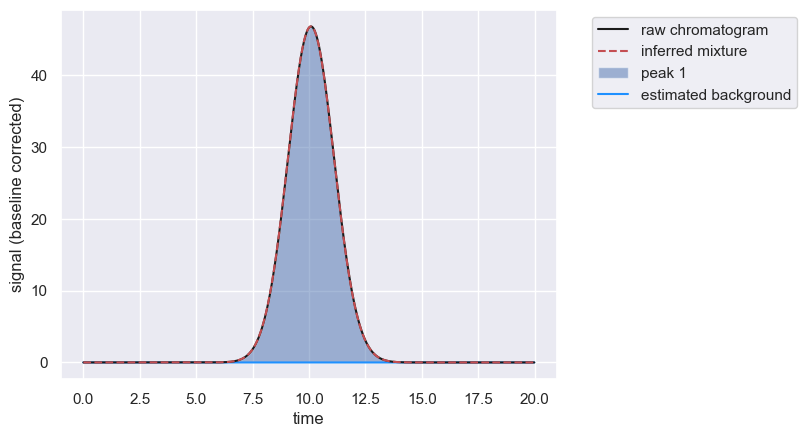

In [40]:
# View the result of the fitting. 
chrom.show()

You can also call `assess_fit()` to see how well the chromatogram is described
by the inferred mixture. This is done through computing a reconstruction score $R$ 
defined as 
$$
R = \frac{\text{Area estimated through inference} + 1}{\text{Area observed in signal} + 1}.
$$
This is computed for regions with peaks (termed "peak windows") and regions of 
background (termed "interpeak windows") if they are present.

In [41]:
# Print out the assessment statistics. 
scores = chrom.assess_fit()
scores.head()


-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 2.910 - 17.460) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 2.900) R-Score = 1.0000 & Fano Ratio = 0
A+, Success:  Interpeak Window 2 (t: 17.470 - 19.990) R-Score = 1.0000 & Fano Ratio = 0

--------------------------------------------------------------------------------


,window_id,time_start,time_end,signal_area,inferred_area,signal_variance,signal_mean,signal_fano_factor,reconstruction_score,window_type,applied_tolerance,status
0,1,0.00,2.90,1.0,1.000000,0.00000,1.000000e-09,0.000000,1.000000,interpeak,0.01,valid
1,2,17.47,19.99,1.0,1.000000,0.00000,1.000000e-09,0.000000,1.000000,interpeak,0.01,valid
0,1,2.91,17.46,12001.0,12001.463355,204.39806,8.241758e+00,24.800298,1.000039,peak,0.01,valid


## Quantifying Peaks

If you know the parameters of the linear calibration curve, which relates peak area
to a known concentration, you can use the `map_compounds` method which will map user provided compound names 
to peaks.

In [11]:
# Define the two peaks of interest and their calibration curves
calibration = {'compound A': {'retention_time': 15.5,
                              'slope': 10547.6,
                              'intercept': -205.6,
                              'unit': 'µM'},
               'compound B': {'retention_time': 17.2,
                              'slope': 26401.2,
                              'intercept': 54.2,
                              'unit': 'nM'}}
quant_peaks = chrom.map_peaks(calibration)
quant_peaks

,retention_time,scale,skew,amplitude,area,peak_id,compound,concentration,unit
0,15.53,0.314009,1.621208,15061.835818,1.807420e+06,4,compound A,171.377934,µM
0,17.29,0.348123,1.705571,12525.991656,1.503119e+06,6,compound B,56.931685,nM


Successfully mapping compounds to peak ID's will also be reflected in the `show`
method.

[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

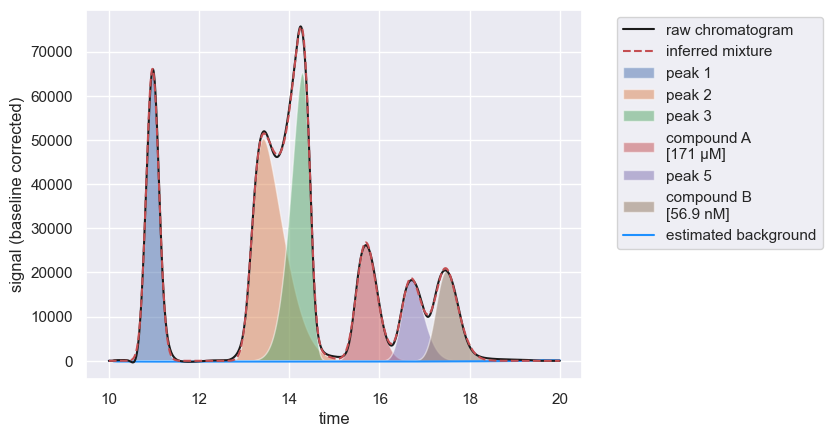

In [13]:
# Show the chromatogram with mapped compounds
chrom.show()

## Deconvolving Overlapping and Subtle Peaks
Often, compounds will have similar retention times leading to heavily overlapping peaks. If one of the compounds dominates the signal, the other compounds may only show up as a "shoulder" on the predominant peak. In this case, automatic peak detection will fail and will fit only a single peak, as in the following example.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

F, Failed:  Peak Window 1 (t: 1.810 - 21.090) R-Score = 0.9788
Peak mixture poorly reconstructs signal. You many need to adjust parameter bounds 
or add manual peak positions (if you have a shouldered pair, for example). If 
you have a very noisy signal, you may need to increase the reconstruction 
tolerance `rtol`.

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 1.800) R-Score = 0.9963 & Fano Ratio = 10^-5
C-, Needs Review:  Interpeak Window 2 (t: 21.100 - 24.990) R-Score = 1.2596 & Fano Ratio = 0
Interpeak window 2 is not well reconstructed by mixture, but has a small Fano factor  
compared to peak region(s). This is likely acceptable, but visually check this region.


--------------------------------------------------------------------------------


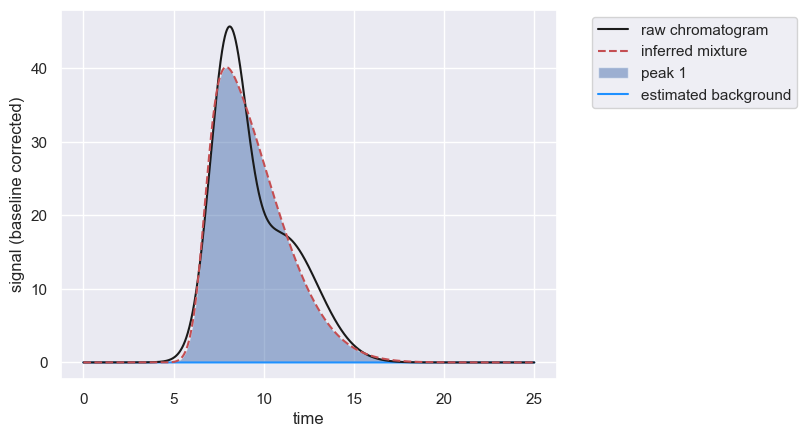

In [15]:
# Load, fit, and display a chromatogram with heavily overlapping peaks
df = load_chromatogram('data/example_overlap.txt', cols=['time', 'signal'])
chrom = Chromatogram(df)
peaks = chrom.fit_peaks()
chrom.show()
score = chrom.assess_fit()

However, if you *know* there is a second peak, and you know its approximate retention time, you can manually add an approximate peak position, forcing the algorithm to 
estimate the peak convolution including more than one peak.

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 1.810 - 21.090) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 1.800) R-Score = 1.0145 & Fano Ratio = 10^-5
A+, Success:  Interpeak Window 2 (t: 21.100 - 24.990) R-Score = 1.0019 & Fano Ratio = 0

--------------------------------------------------------------------------------


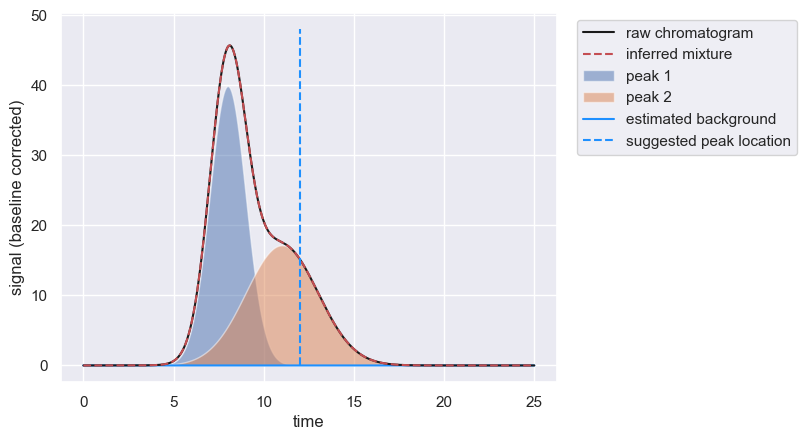

In [16]:
# Enforce a manual peak position at around 11 time units
peaks = chrom.fit_peaks(known_peaks=[12])
chrom.show()
score = chrom.assess_fit()


Note that even though we provided a guess of ≈ 12 time units for the position of the second peak, the algorithm did not force the peak to be exactly there. If `enforced_locations` are 
provided, these are used as initial guesses when performing the fitting.

This approach can also be used if there is a shallow, isolated peak that is not
automatically detected.

Performing baseline correction:   0%|          | 0/249 [00:00<?, ?it/s]

Deconvolving mixture: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 2.910 - 17.080) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 2.900) R-Score = 1.0000 & Fano Ratio = 0
F, Failed:  Interpeak Window 2 (t: 17.090 - 79.990) R-Score = 10^-3 & Fano Ratio = 0.0369
Interpeak window 2 is not well reconstructed by mixture and has an appreciable Fano 
factor compared to peak region(s). This suggests you have missed a peak in this 
region. Consider adding manual peak positioning by passing `known_peaks` 
to `fit_peaks()`.

--------------------------------------------------------------------------------


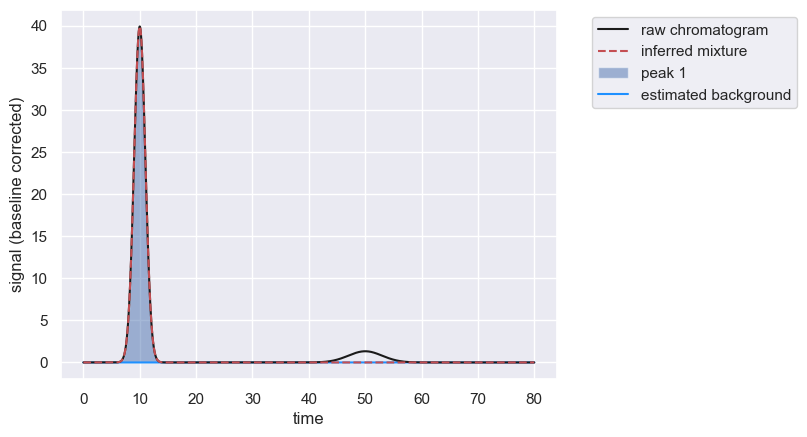

In [17]:
# Load and fit a sample with a shallow peak
df = load_chromatogram('data/example_shallow.csv', cols=['time', 'signal'])
chrom = Chromatogram(df)
peaks = chrom.fit_peaks(prominence=0.5) # Prominence is to exclude shallow peak
chrom.show()
score = chrom.assess_fit()

As the second peak is broad, you can provide an estimate of the width of the peak at the half maximum value 
to provide a better initial guess.

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s]



-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 2.910 - 17.080) R-Score = 1.0000
A+, Success:  Peak Window 2 (t: 45.000 - 54.990) R-Score = 1.0000

Signal Reconstruction of Interpeak Windows
                  
A+, Success:  Interpeak Window 1 (t: 0.000 - 2.900) R-Score = 1.0000 & Fano Ratio = 0
A+, Success:  Interpeak Window 2 (t: 17.090 - 44.990) R-Score = 1.0016 & Fano Ratio = 0.0154
A+, Success:  Interpeak Window 3 (t: 55.000 - 79.990) R-Score = 1.0002 & Fano Ratio = 0.0153

--------------------------------------------------------------------------------


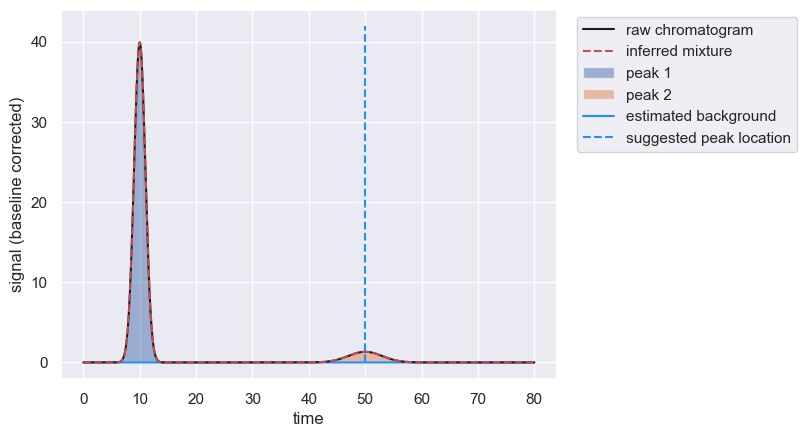

In [18]:
# Add the location of the second peak
peaks = chrom.fit_peaks(known_peaks={50 : {'width': 5}}, prominence=0.5)
chrom.show()
score = chrom.assess_fit()

## Constraining Peaks With Known Parameters
If you have a chromatogram with two *completely* overlapping peaks, it can be 
very, very difficult to deconvolve the mixture. However, if you happen to know
the parameters of one of the constituents (say, from characterization of 
an isolated aqueous mixture of that compound), you can apply more stringent 
bounds to that particular peak. Say for example we have a mixture of two compounds 
with retention times of `10` and `10.6` and you know that the first peak has 
an amplitude of `100` units. If you were to only supply the locations of the 
known peaks, you would underestimate the contribution from the first peak.

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

Inferred amplitude for peak 1 is 94.971. Known value is 100.000


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

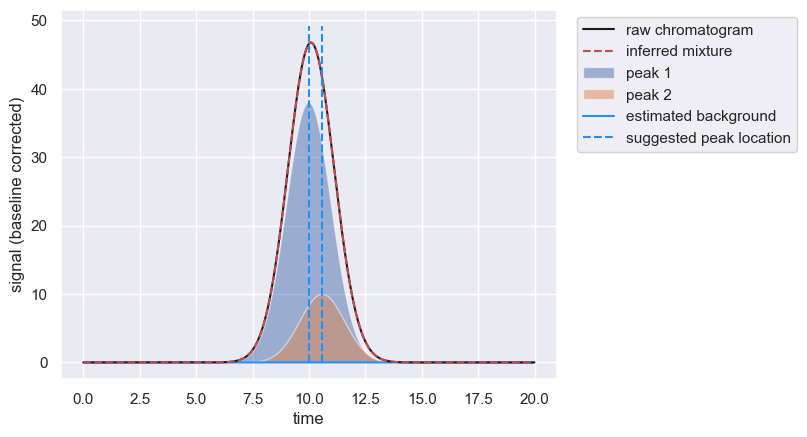

In [19]:
# Load a chromatogram that is very heavily overlapping
df = load_chromatogram('data/bounding_example.csv', cols=['time', 'signal'])
chrom = Chromatogram(df)

# Fit the peaks providing only the known retention times
peaks = chrom.fit_peaks(known_peaks = [10, 10.6])
inferred_amplitude = peaks[peaks['peak_id']==1]['amplitude'].values[0]
known_amplitude = 100

# Print a summary statement demonstrating the underestimation 
print(f'Inferred amplitude for peak 1 is {inferred_amplitude:0.3f}. Known value is {known_amplitude:0.3f}')
chrom.show()

You can constrain the parameter bounds for the amplitude of peak 1 more narrowly 
than the other peak by passing a dictionary to the `known_peaks` parameter of `fit_peaks()`.

Deconvolving mixture:   0%|          | 0/2 [00:00<?, ?it/s]

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

Inferred amplitude for peak 1 is 99.000. Known value is 100.000


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time', ylabel='signal (baseline corrected)'>]

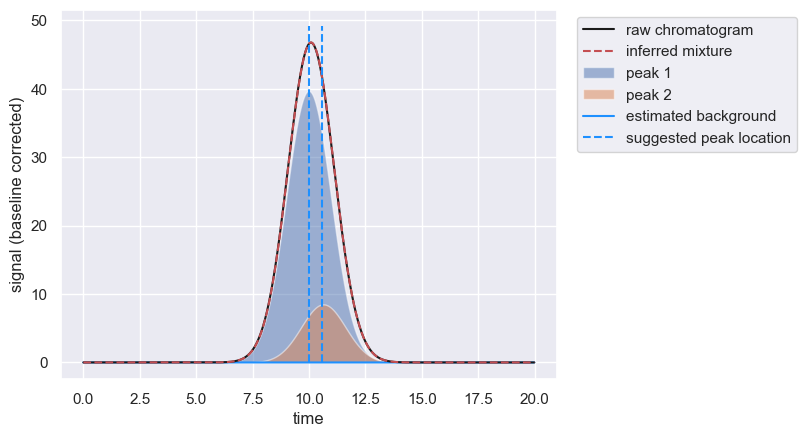

In [20]:
# Define more stringent bounds as a dictionary with the retention time as the key
# and the parameter bounds as a value.
bounds = {10: {'amplitude':[99, 101]}, # Known parameters for peak 1
          10.6 : {} # Allow free inference for second peak
          }
peaks = chrom.fit_peaks(known_peaks=bounds)
inferred_amplitude = peaks[peaks['peak_id']==1]['amplitude'].values[0]

# Print a summary statement demonstrating the improvement.
print(f'Inferred amplitude for peak 1 is {inferred_amplitude:0.3f}. Known value is {known_amplitude:0.3f}')
chrom.show()

Here, we've only bounded the `amplitude` parameter, but you can also provide 
bounds for `location`, `scale`, and `skew`.

---

<small> © Griffin Chure, 2023. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>